# Manipulating fMRI data and computing a connectome

## Loading the data

For this tutorial, we will use the data provided by the `nilrean.datasets` module.
We first download some fMRI data from 1 subject

In [1]:
from nilearn import datasets

data_dir = None # change this variable with the path where you want nilearn to download
                # the data, if you leave None, the default will be '~/nilearn_data'
    
# Loading the functional datasets
# n_subjects=1 代表只取一位受試者的資料
data = datasets.fetch_development_fmri(n_subjects=1, data_dir=data_dir)

# you can use the .keys() method to check what's in the dataset
data.keys()


dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [2]:
# We can check the description of the dataset to know what we're dealing with 
print(data.description) # the .decode("utf-8") is used because the description is a bytestring

The movie watching based brain development dataset (fMRI)


Notes
-----
This functional MRI dataset is used for teaching how to use
machine learning to predict age from naturalistic stimuli (movie)
watching with Nilearn.

The dataset consists of 50 children (ages 3-13) and 33 young adults (ages
18-39). This dataset can be used to try to predict who are adults and
who are children.

The data is downsampled to 4mm resolution for convenience. The original
data is downloaded from OpenNeuro.

For full information about pre-processing steps on raw-fMRI data, have a look
at README at https://osf.io/wjtyq/

Full pre-processed data: https://osf.io/5hju4/files/

Raw data can be accessed from : https://openneuro.org/datasets/ds000228/versions/1.0.0

Content
-------
    :'func': functional MRI Nifti images (4D) per subject
    :'confounds': TSV file contain nuisance information per subject
    :'phenotypic': Phenotypic information for each subject such as age,
                   age group, gender,

In [3]:
# data.func contains the paths to the Nifti files (the files containing fMRI data)
fmri_filepath = data.func[0]
print(fmri_filepath)

/home/rubycheng/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [4]:
# We can load a Nifti file with the nibabel library
import nibabel as nib

fmri_img = nib.load(fmri_filepath)
print(fmri_img)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (50, 59, 50, 168)
affine:
[[   4.    0.    0.  -96.]
 [   0.    4.    0. -132.]
 [   0.    0.    4.  -78.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  50  59  50 168   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 4. 4. 4. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : align

So this is a `Nifti1Image` object which contains 3 things :
* some data of shape (50, 59, 50, 168)
* an affine array that defines the spatial orientation and scale of the data
* a header, containing more information about the data format

Note that the data is a 4D array. The last dimension is the time, so we have 168 volumes, and from the 5th value of the pixdim array in the header we can see that the t_r is 1s, so we have a file that represents 168s of scanning. 

For each time point we have a 3D array that contains the voxels. But not all these voxels correspond to the brain.

In [5]:
# let's get the data array 
fmri_data = fmri_img.get_fdata()
fmri_data.shape

(50, 59, 50, 168)

We can choose a voxel (for example the one with coordinates 25, 30, 25) and plot its time series :

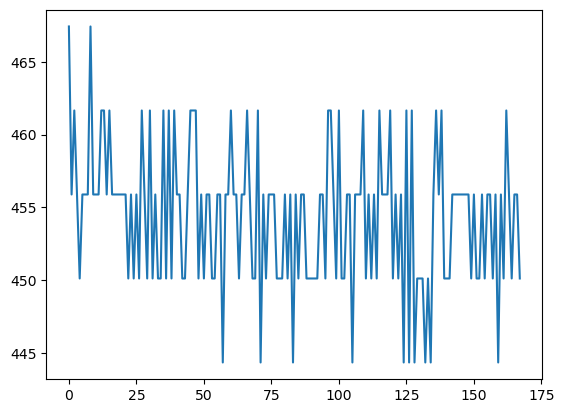

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fmri_data[25,30,25])

We can also plot a slice of our brain for a time point as an image, for example a transversal slice for the first time point and z=25 : 

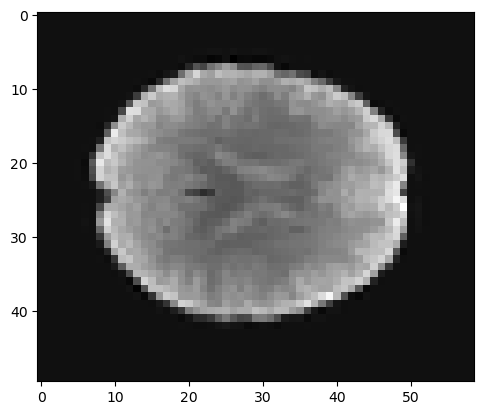

In [7]:
plt.imshow(fmri_data[:,:,25,0], cmap='gray')

Here all the black pixels in our image are voxels present in our `fmri_data` array but not containing any brain. Thus we want to exclude all these empty voxels just to keep the ones containing brain data. To do that we're gonna use a **masker**. 

## Masking the data

The masker not only removes the background voxels, but it can also regress out the confounds if you provide them.

In short, the confounds are external sources of signal you want to remove, such as the movement of the head. Regressing out the confounds means removing the part of the signal correlated to the sources of noise. For example we can remove the part of the signal that correlates with the head motion because we consider this part of signal to be only artefacts caused by the movements and not relevant for brain activity. 

Confounds handling is in reality more complicated than that, if you want to learn more you can check the [fMRIprep documentation](https://fmriprep.org/en/stable/outputs.html#confounds).

In [8]:
from nilearn.input_data import NiftiMasker

masker = NiftiMasker()
masked_data = masker.fit_transform(fmri_filepath, confounds=data.confounds)
masked_data.shape

/home/rubycheng/miniconda3/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


(168, 32504)

Now you see that our array has a different shape, we have our time dimension first with still 168 time points, but for each time point, instead of a 3D volume, we have a 1D array. 

Also note that we kept 32,504 voxels, when whe had a total of 50*59*50 = 147,500, so we got rid of a lot of empty voxels. That is good, but the downside is that we lost the spatial information of where these voxels are in the brain. But don't worry because the masker remembers it. If we want to recover this information and turn back our 1D arrays into 3D spatial ones we can uste the `makser.inverse_transform` method.

For example if we want to threshold our fMRI data by the mean and then plot ther result we can do it this way :

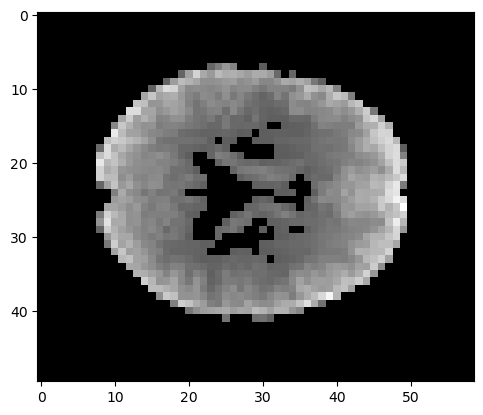

In [9]:
thresholded_masked_data = masked_data * (masked_data > masked_data.mean()) 
#This effectively thresholds the data to remove any low-amplitude noise.

thresholded_img = masker.inverse_transform(thresholded_masked_data)
#(thresholded_masked_data is a 2D numpy array of the fMRI data after applying a threshold to it. The masker.inverse_transform method is then used to convert the thresholded data into a 3D Nifti image object, where each voxel in the image has the same value as its corresponding voxel in thresholded_masked_data.)

plt.imshow(thresholded_img.get_fdata()[:,:,25,0], cmap='gray')

**NOTE**: In this example we instantiated a `NiftiMasker` without providing any argument, 
however depending on the data used, we might want to use specific strategies to remove the
background voxels, and we can ask the masker to do some complementrary processing such as 
standardizing the data, deterending it or resampleing it. In real-life use cases you should carefully 
choose the arguments to provide to the `NiftiMasker`. These arguments are explained in 
the [nilearn documentation](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html).

## Using an atlas

Having removed the empty voxels is great, and we could directly compute a connectome on the masked data,
but it would create a 32,504 by 32,504 matrix, which would be a bit hard to analyse.

An easier way to manipulate the data would be to use an atlas, that defines region of interest (ROIs). We could create our own atlas by clustering the voxels, but hopefully nilearn provides ready-made atlases, let's load one.

## the mask method is different from the atlas-based method 
the mask method and the atlas-based method are different ways of defining regions of interest (ROIs) to extract time series data from an fMRI dataset

The mask method uses a binary mask image to select a set of voxels that belong to a particular brain region or cluster of regions. The binary mask is typically created by thresholding a statistical map or using an anatomical atlas.

In contrast, the atlas-based method uses an atlas image that defines a set of ROIs as separate regions of the brain. The atlas image typically contains multiple regions, and each region is represented by a unique label or index.

The main advantage of the mask method is that it allows for more flexibility in defining the ROIs, since the user can create custom masks that are tailored to their specific research question. The main advantage of the atlas-based method is that it provides a standardized set of ROIs that can be compared across subjects and studies, since the same atlas can be applied to multiple datasets.

In [10]:
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels

We now have the path to the Nifti file containing the ROIs info in `atlas_filepath` and the names of the ROIs in `labels`.

To apply the atlas on our data, we can once again use a masker, but this time a `NiftiMapsMasker`.

In [11]:
from nilearn.input_data import NiftiMapsMasker

atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)

data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=data.confounds)
data_in_atlas.shape

(168, 39)

We see that now we only have 39 values per time point, so we have 39 ROIs. This is more appropriate to compute a connectivity matrix.

We can plot the time series in a ROI (for example the 5th one) :

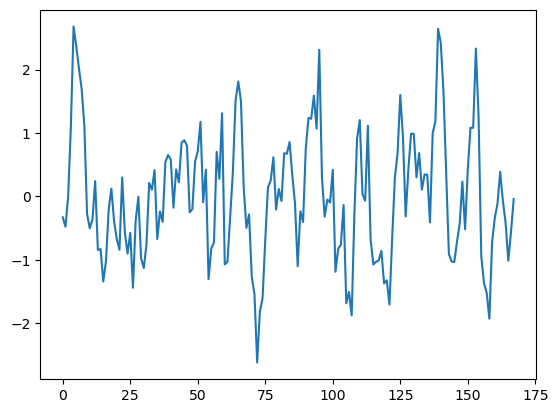

In [12]:
plt.plot(data_in_atlas[:,4])

**Note**: Depending on the type of atlas you use, you might have to use different kinds of masker. Here we have probabilistic overlapping regions, so we use a `NiftiMapsMasker`, but if we had non-overlapping regions, we would use a `NiftiLabelsMasker`.

## Connectome

Let's compute and plot a correlation matrix !

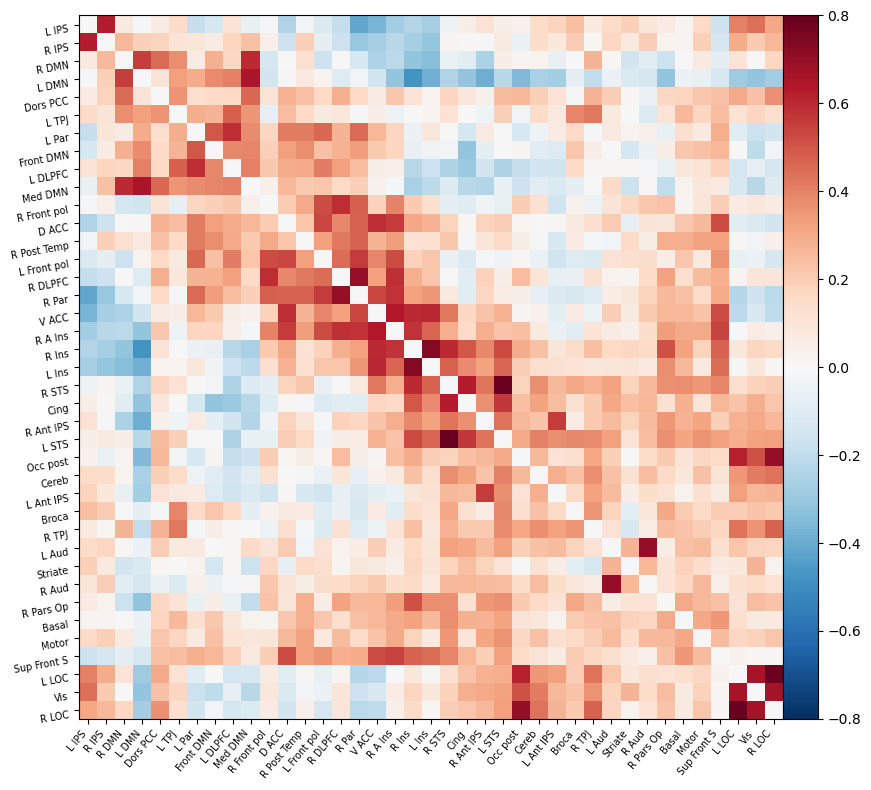

In [13]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The matrix is reordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

## Plotting

Earlier we simply plotted a slice of our brain with matplotlib. It works and it is a fine way to check your data array. However for more complex or fancy plots, nilearn comes with a lot of handy tools in its `nilearn.plotting` module. Here are a few examples.

* To view a 3D NiftiImage object, the `view_img` functions makes it easy to interactively go through the slices.

/home/rubycheng/miniconda3/lib/python3.10/site-packages/nilearn/plotting/html_stat_map.py:111: UserWarning: Threshold given was 1e-06, but the data has no values below -116.0191650390625. 
  warnings.warn("Threshold given was {0}, but "
/home/rubycheng/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



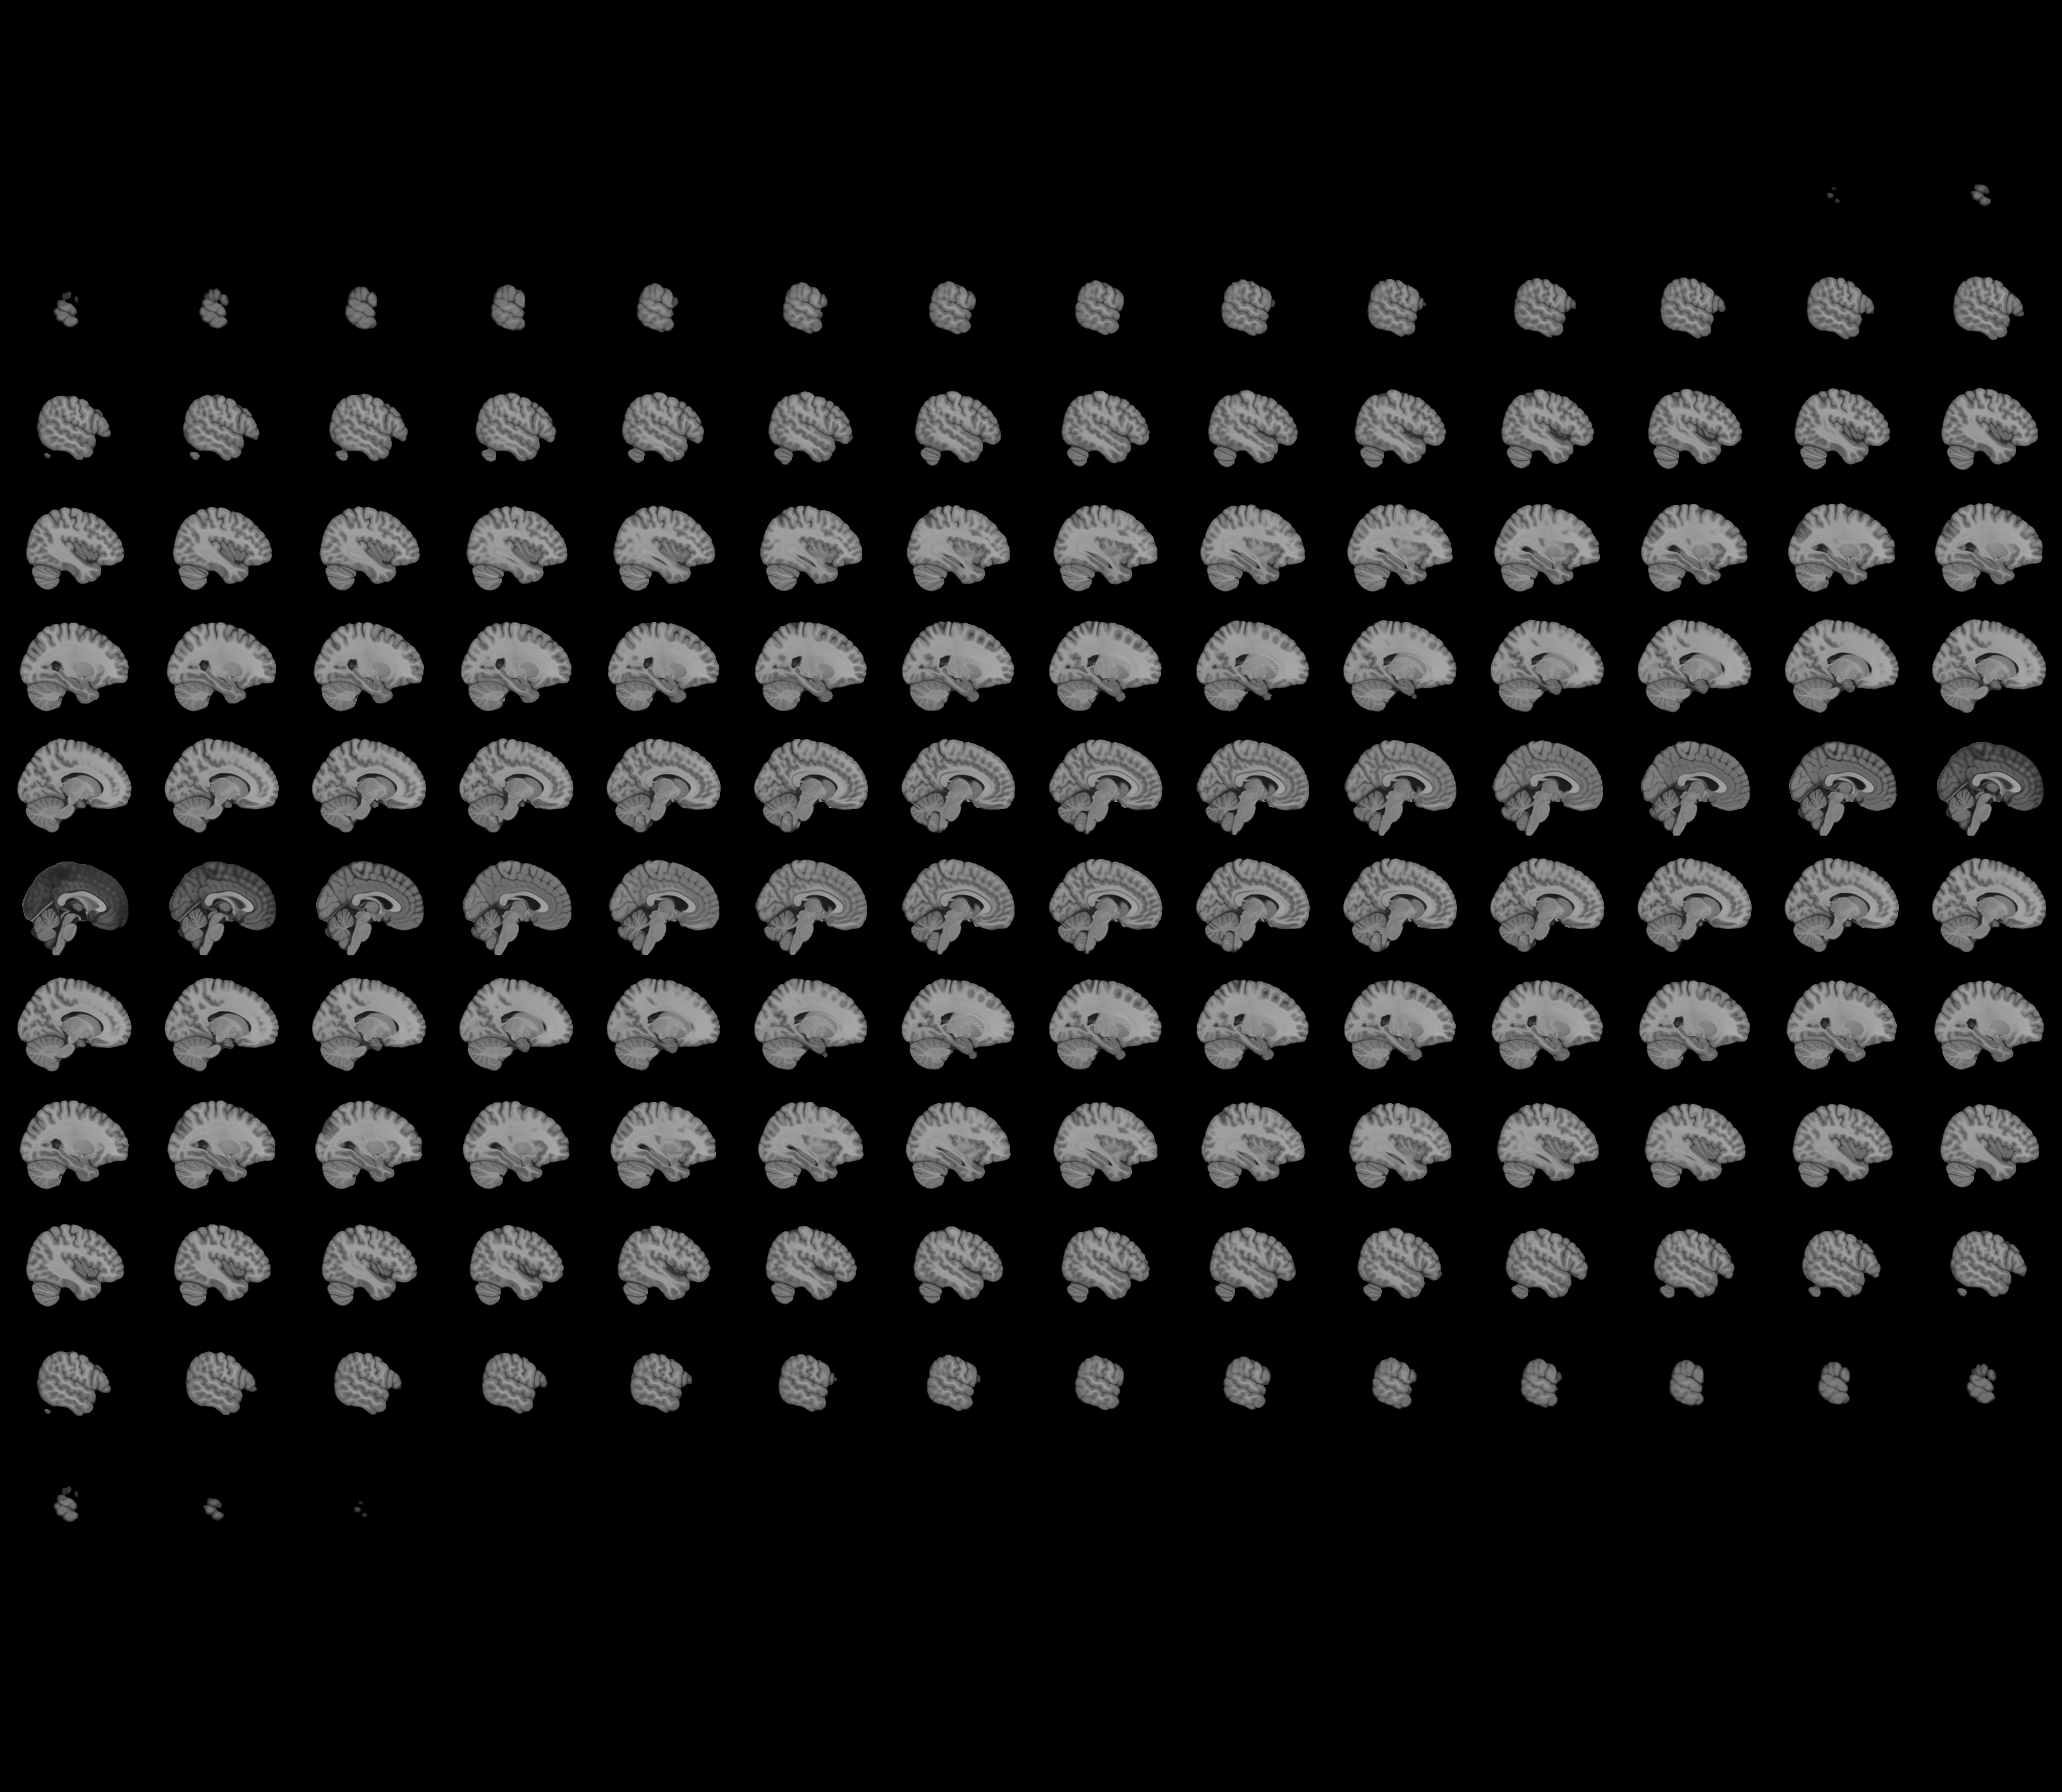
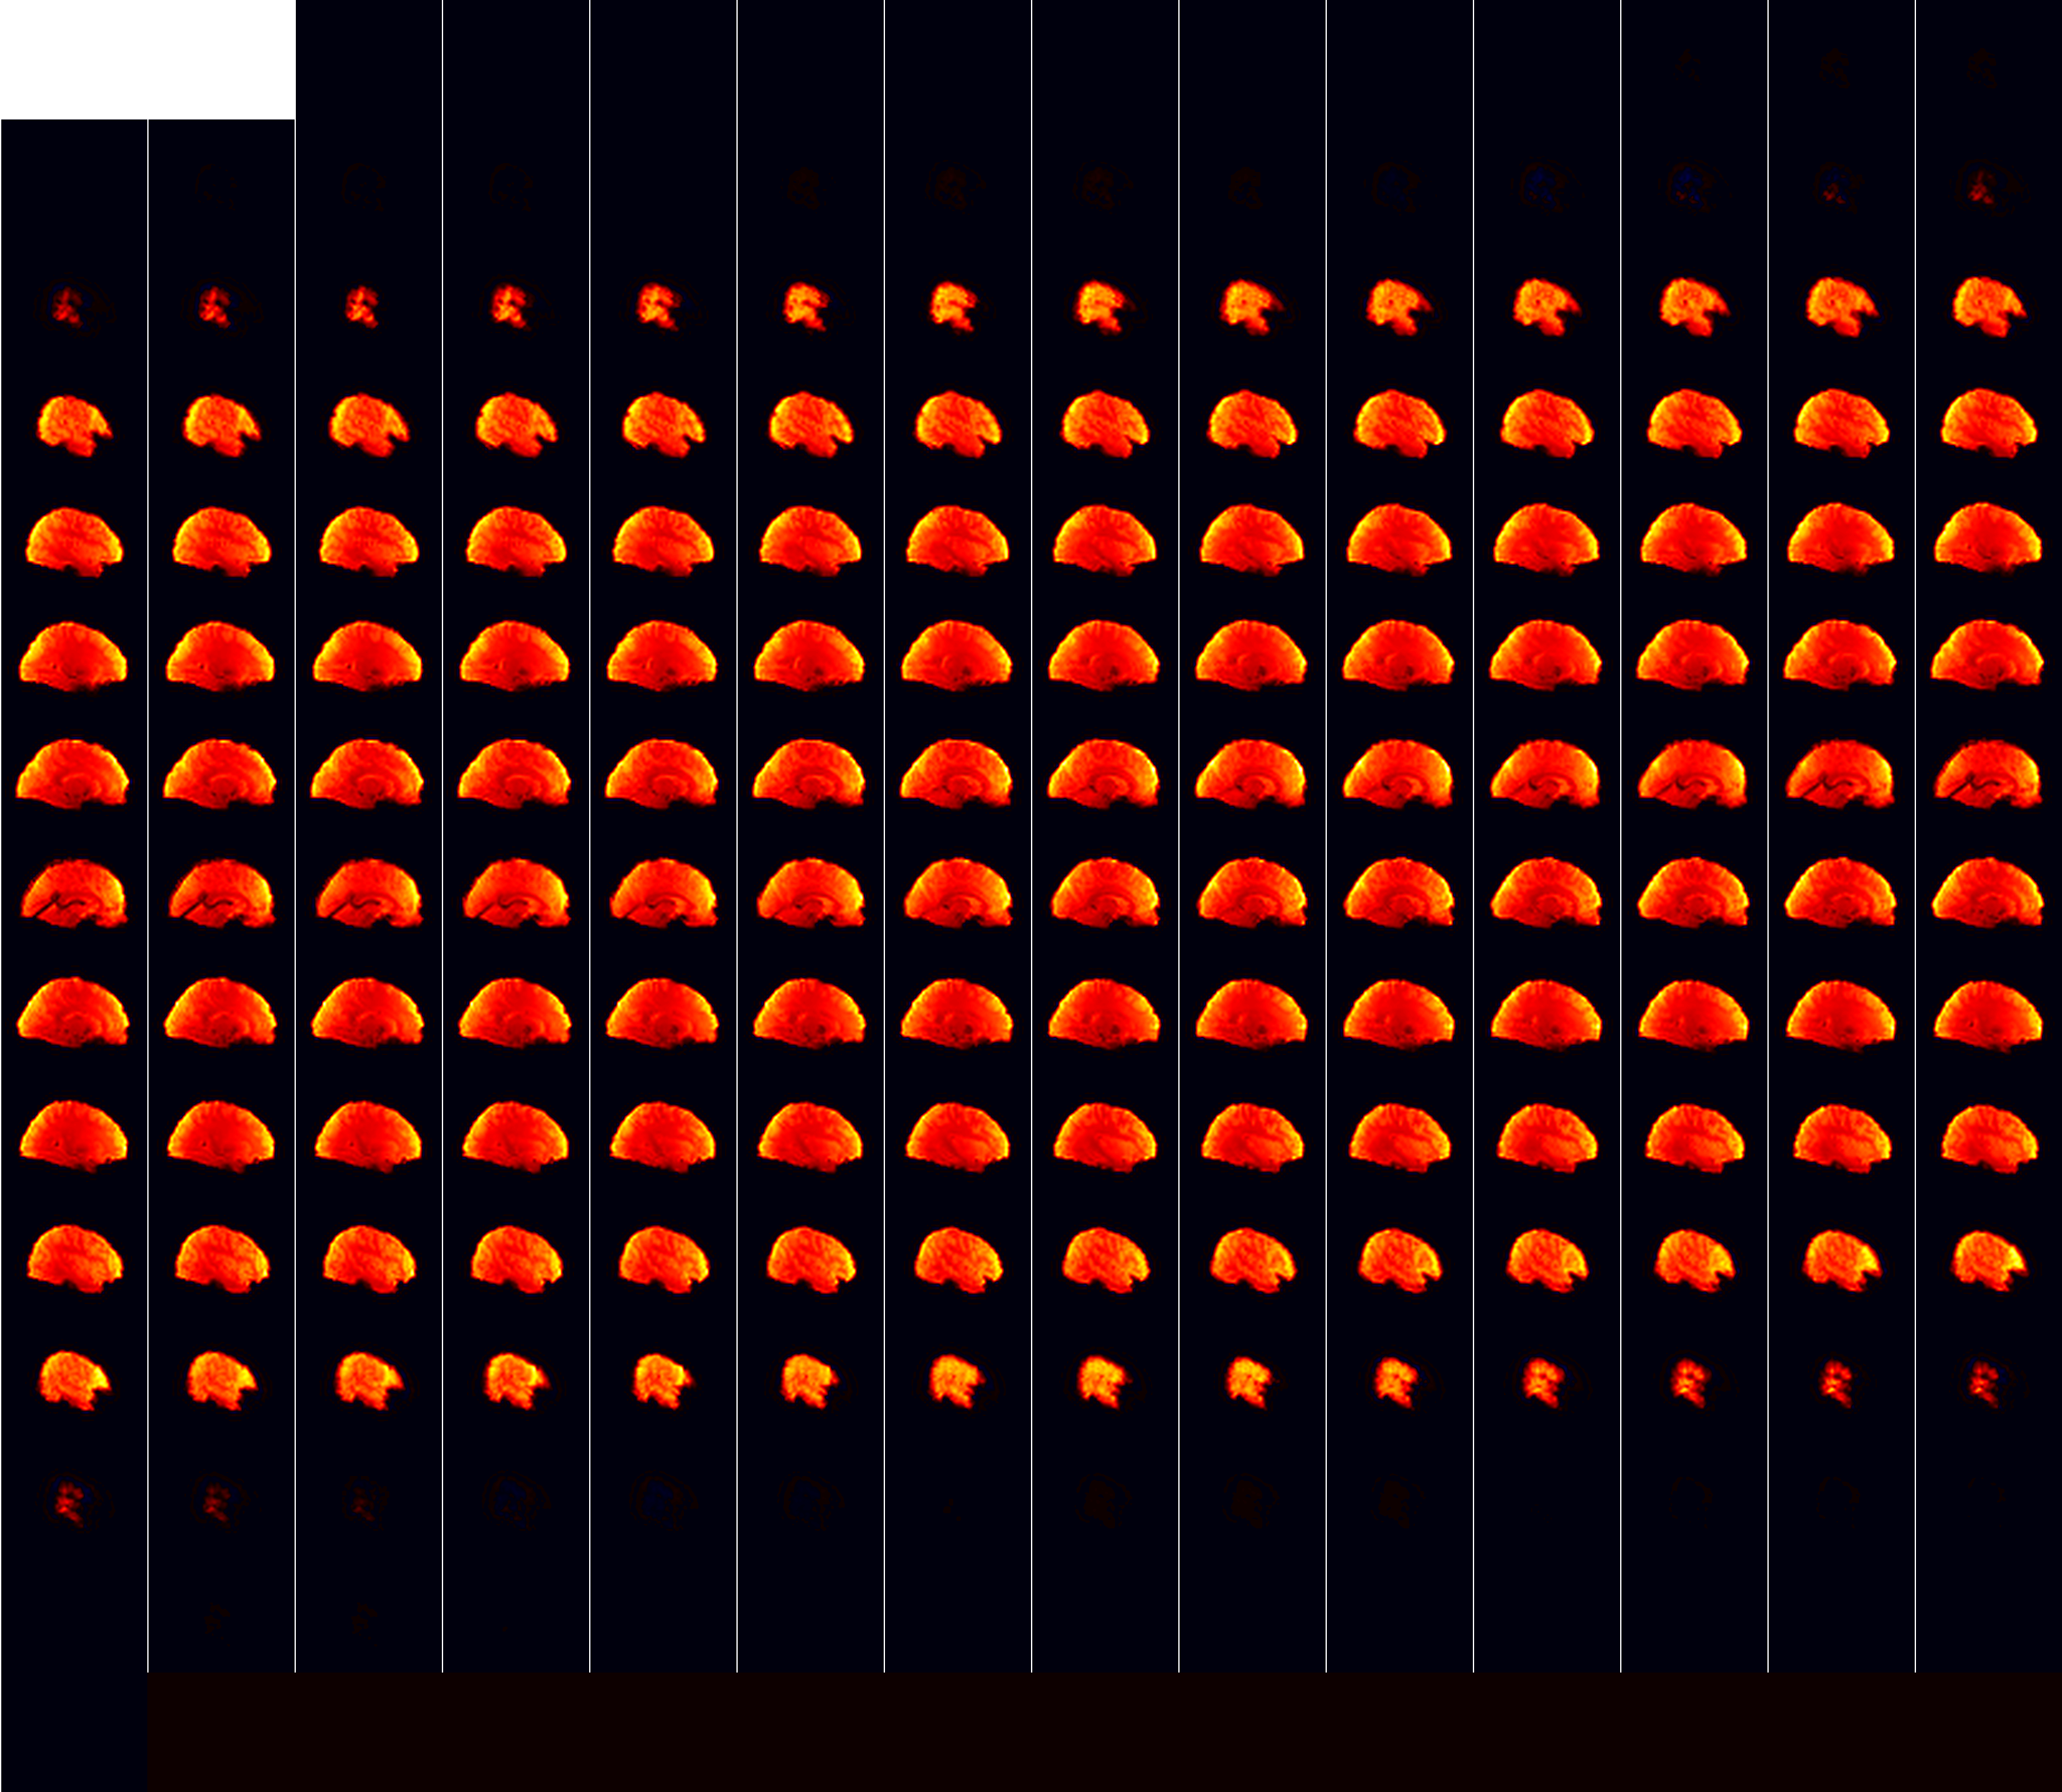

In [14]:
from nilearn.plotting import view_img

# Since our fmri_img is a 4D NiftiImage, we need to generate a 3D one.
# One way of doing that is averaging our volumes on the time axis 
# with the mean_img function.
from nilearn.image.image import mean_img

fmri_img_mean = mean_img(fmri_img)
view_img(fmri_img_mean)

* To display the graph corresponding to a connectome, you can use `plot_connectome`.

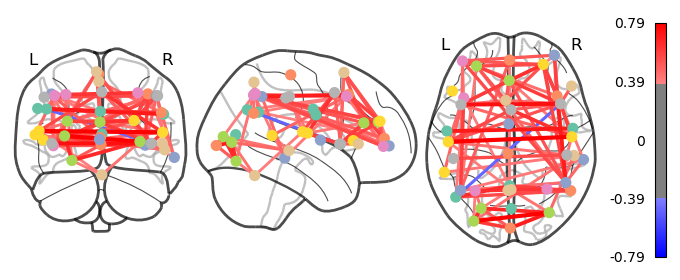

In [15]:
from nilearn.plotting import plot_connectome

coords = atlas_dataset.region_coords

# We threshold to keep only the 10% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="90%", colorbar=True)

To discover more ways of generating super cool visuals of brains, check the [nilearn plotting documentation](https://nilearn.github.io/plotting/index.html).

# Exercises

## 1. Of the importance of confounds

* Generate a correlation matrix with the same data, but this time without using the confounds when masking.

How does that impact the correlation matrix ?
Why do you think it affects the matrix this way ?

* Plot the obtained connectome in 3D using `nilearn.plotting.view_connectome` (check [the doc](https://nilearn.github.io/modules/generated/nilearn.plotting.view_connectome.html) to know how to use it).

In [16]:
#解法2。
from nilearn.input_data import NiftiMasker

# extract time series from all subjects
masker2 = NiftiMasker()
masked_data2 = masker2.fit_transform(fmri_filepath, confounds=None)
masked_data2.shape

# confounds=None -> 
# This is useful when you want to preprocess the data without regressing out any potential sources of noise.

# confounds=data.confounds ->
# regress out potential sources of noise from the fMRI data (motion or physiological noise)

(168, 32504)

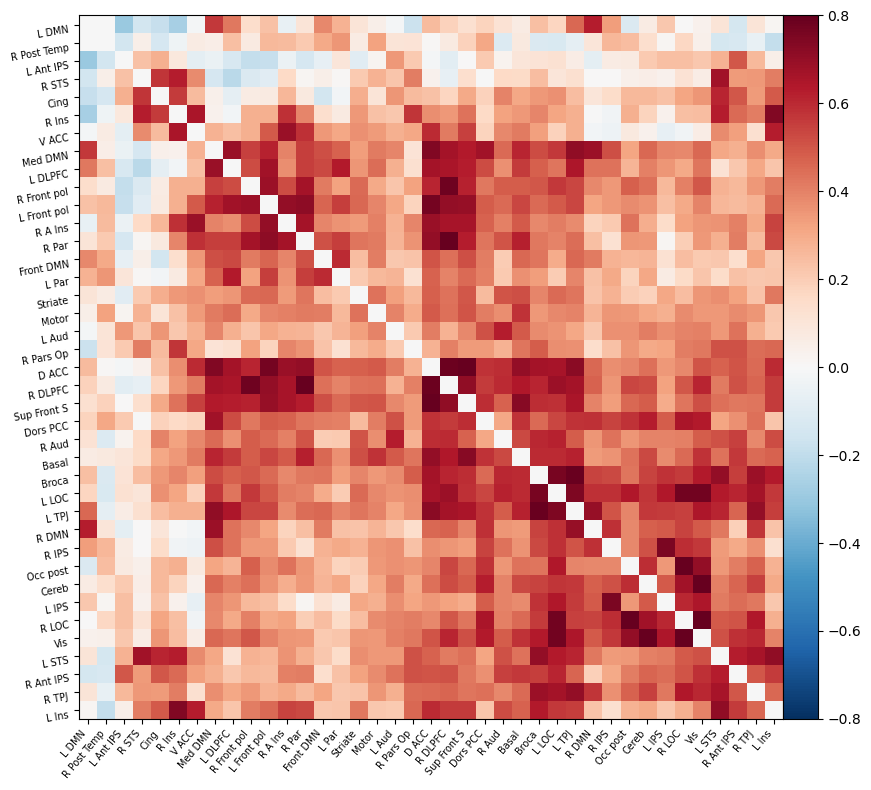

In [17]:
data_in_atlas_2 = atlas_masker.fit_transform(fmri_filepath)
correlation_matrix_2 = correlation_measure.fit_transform([data_in_atlas_2])[0]
np.fill_diagonal(correlation_matrix_2, 0)
plotting.plot_matrix(correlation_matrix_2, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

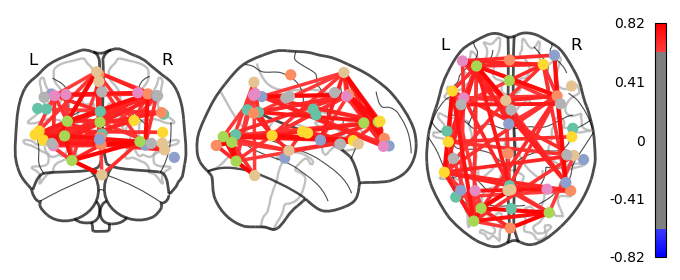

In [18]:
plotting.plot_connectome(correlation_matrix_2, coords,
                         edge_threshold="90%", colorbar=True)

Not regressing out the confounds may impact the correlation matrix by introducing spurious correlations that are not related to the neural activity of interest. Confounds such as head motion, heart rate, or respiration can introduce noise in the fMRI signal that may be correlated with the signal from the ROIs, leading to artificially inflated correlations.

## 2. Visualizing the atlas and a specific time point

* Use `view_img` to visualize the 5th ROI of the atlas. (Hint: use the atlas masker to inverse transform an array with 1 at the index 4 and 0 every where else.)

* Use `plotting.plot_prob_atlas` to show all the ROIs with filled contours. (Hint: check the nilearn documentation to see how to use `plotting.plot_prob_atlas`).
* Earlier we used `view_img` to plot the mean volume of our `fmri_img` data because `view_img` doesn't accept 4D images but only 3D ones. Find a way to generate a 3D Nifti image with the 84th time point in `fmri_img` and plot it with `view_img`.

/home/rubycheng/miniconda3/lib/python3.10/site-packages/nilearn/plotting/html_stat_map.py:111: UserWarning: Threshold given was -1e-05, but the data has no values below 0.0. 
  warnings.warn("Threshold given was {0}, but "
/home/rubycheng/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/rubycheng/miniconda3/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/home/rubycheng/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/rubycheng/miniconda3/lib/python3.10/site-packages/numpy/

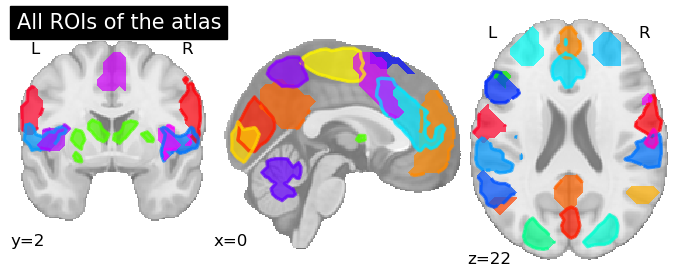

In [19]:
import numpy as np
from nilearn.image import index_img, new_img_like, load_img
from nilearn.plotting import view_img, plot_prob_atlas

## Define the atlas masker
atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True) 
#(standardize=True means that the time series of each voxel within each region of interest (ROI) will be standardized, or z-scored, across time.)
atlas_masker.fit() # fit the masker to the atlas file

## Inverse transform an array with 1 at the index 4 and 0 everywhere else
inv_transformed = atlas_masker.inverse_transform(np.eye(len(labels))[4]) 
#(Python uses zero-based indexing, so the 5th row has an index of 4)
#(to create a Nifti image with a binary mask corresponding to the 5th ROI of the atlas, and then uses view_img to display the image.)

## Visualize the 5th ROI of the atlas using view_img
view_img(inv_transformed, threshold='auto', cmap='viridis', symmetric_cmap=False, colorbar=True, title='5th ROI of the atlas')

## Generate a 3D Nifti image with the 84th time point in fmri_img
t84_img = index_img(fmri_img, 83)  
# (note that 83 corresponds to the 84th time point (zero-based index))
# (uses nilearn.image.index_img to extract the 3D Nifti image corresponding to the 84th time point of fmri_img)

## Plot the 3D Nifti image using view_img
view_img(t84_img, threshold='auto', cmap='gray', symmetric_cmap=False, colorbar=True, title='84th time point of fmri_img')

## Plot all the ROIs with filled contours using plotting.plot_prob_atlas
plot_prob_atlas(atlas_filepath, view_type='filled_contours', draw_cross=False, cut_coords=None, output_file=None, title='All ROIs of the atlas')


## 3. Seed-based connectivity

* Using the information provided in [this nilearn tutorial](https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html), plot the seed-to-voxel correlation map of our fmri_img for the seed of coordinates (-16, -74, 7) and with a sphere mask of radius of size 10. 

In [36]:
from nilearn.input_data import NiftiSpheresMasker
import numpy as np

# Define the sphere seed coordinates and radius
seed_coords = [[-16, -74, 7]]
radius = 10

# Create a masker with a sphere mask
seed_masker = NiftiSpheresMasker(
    seed_coords,
    radius=10,
    detrend=True,
    standardize=True, low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

# Extract the time series for the seed
#(apply the mask defined by the sphere around the seed coordinates to the fMRI data, and return the resulting time series data.)
seed_time_series = seed_masker.fit_transform(fmri_filepath, confounds =  data.confounds)

from nilearn.input_data import NiftiMasker
masker = NiftiMasker()
brain_time_series = masker.fit_transform(fmri_filepath, confounds=data.confounds)

# Compute the correlation between the seed and all other voxels
correlation_map = np.dot(brain_time_series.T, seed_time_series) / seed_time_series.shape[0]
#(You're computing the correlation between the time series of the voxels in the seed region and the time series of all other voxels in the brain, to see which regions have similar activity patterns to the seed.)

seed_to_voxel_correlations_img = masker.inverse_transform(
    correlation_map.T)

display = plotting.plot_stat_map(seed_to_voxel_correlations_img,
                                 threshold=0.5, vmax=1,
                                 cut_coords=vis_coords[0],
                                 title="Seed-to-voxel correlation (VIS seed)"
                                 )
display.add_markers(marker_coords=seed_coords, marker_color='g',
                    marker_size=300)

ValueError: Please provide mask_img at initialization to provide a reference for the inverse_transform.